### Problem Statement

Using only the text column in the csv file, predict 2 continous variables.

### Import Relevant Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import FunctionTransformer
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor

In [2]:
from nltk.corpus import stopwords

In [3]:
german_stop_words = stopwords.words('german')

In [4]:
df = pd.read_csv('raalucaa-attachments/training.txt', header=None)
test = pd.read_csv('raalucaa-attachments/validation.txt', header=None)

In [5]:
def rename_cols(x):
    x.rename(mapper={0:'ID', 1:'target_1',2:'target_2',3:'text'}, axis=1, inplace=True)
def new_csv(x,to_drop,new):
    x.drop(columns=[i for i in to_drop]).to_csv(new, index=False)

In [6]:
rename_cols(df)
rename_cols(test)

### Creating new datasets based on problem statement


In [7]:
### Run only once

# new_csv(df,['target_2'],'training_1.csv')
# new_csv(df,['target_1'],'training_2.csv')

# new_csv(test,['target_2'],'validation_1.csv')
# new_csv(test,['target_1'],'validation_2.csv')

In [8]:
train_1 = pd.read_csv('training_1.csv')
test_1 = pd.read_csv('validation_1.csv')
train_2 = pd.read_csv('training_2.csv')
test_2 = pd.read_csv('validation_2.csv')

### Explore Dataset

In [9]:
train_1.head(3)

,ID,target_1,text
0,119165,51.810067,"Seit d Vase: ""Wenn ich kaputt gang, bringt das..."
1,100377,51.918188,Haha bin au w isch der amig au so richtig lang...
2,109550,52.711074,isch d hiltl dachterrasse amne samstig viel bs...


In [10]:
train_1.ID.nunique() / train_1.shape[0]

1.0

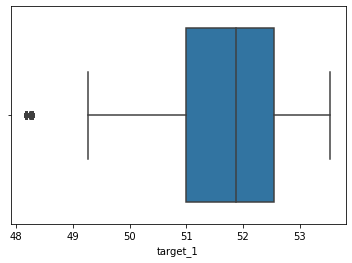

In [11]:
sns.boxplot(x='target_1', data=train_1)

In [12]:
train_1.sample(5).text

2608     Händr e paar gueti summerlieder?? Danke im vor...
15218    Kollegin het mir vom niklas verzellt den Segi ...
13048    Blitzkaste zwüsched wald und rüti bhf.. (fast ...
17274    Ich... Made... ?! NNÄÄÄÄII Gueti protein snack...
2028     Min negste streich wird de si, dassi uf de tür...
Name: text, dtype: object

### Data Cleaning / Preparation

In [13]:
TOKEN_ALPHANUMERIC = '[^a-zA-Z0-9äöüÄÖÜß]'
TOKEN_ALPHABETIC = '[^a-zA-ZäöüÄÖÜß-]'
mae_dict = {}
seed = 0
lr = 0.03
stop = 100

In [14]:
def clean_words(df, token, col):
    '''
    df : Dataframe
    token : regex pattern to keep characters in text 
    col : name of column in Dataframe that contains the text
    '''
    corpus = []
    for i in range(df.shape[0]):
        text = df.iloc[i][col]
        review =  re.sub(token,' ', text).lower() # keep only characters in token 
        corpus.append(review)
    return corpus

1st Model Variation

### Model Building

Train_1

In [15]:
get_clean_train = clean_words(train_1, TOKEN_ALPHANUMERIC, 'text')   #since we're using the same features for training for both tasks.
target_1 = train_1.target_1.values

In [16]:
cvec = CountVectorizer(max_features=8000)
train_vec = cvec.fit_transform(get_clean_train).toarray()

In [17]:
lgb_params_1 = {
 'bagging_fraction': 0.9,
 'feature_fraction': 0.5,
 'learning_rate': 0.03,
 'max_depth': -1,
 'min_child_weight':5,
 'min_split_gain': 0.03,
 'num_iterations': 2000,
 'num_leaves': 500
}

In [18]:
%%time
lgb1 = LGBMRegressor(random_state=seed, 
                     n_estimators = lgb_params_1['num_iterations'], 
                     learning_rate = lgb_params_1['learning_rate'],
                     bagging_fraction = lgb_params_1['bagging_fraction'],
                    feature_fraction = lgb_params_1['feature_fraction'],
                    max_depth = lgb_params_1['max_depth'],
                    min_child_weight = lgb_params_1['min_child_weight'],
                    min_split_gain = lgb_params_1['min_split_gain'],
                    num_leaves = lgb_params_1['num_leaves'])
lgb1.fit(train_vec, target_1)

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Wall time: 1min 19s


LGBMRegressor(bagging_fraction=0.9, feature_fraction=0.5, learning_rate=0.03,
              min_child_weight=5, min_split_gain=0.03, n_estimators=2000,
              num_leaves=500, random_state=0)

In [19]:
get_clean_test = clean_words(test_1, TOKEN_ALPHANUMERIC, 'text')  #since we're making inference on the same features for the 2 tasks.
test_vec = cvec.transform(get_clean_test).toarray()

In [20]:
p1 = lgb1.predict(test_vec)

In [21]:
display(mean_absolute_error(p1, test_1.target_1))
mae_dict['train_1_mae'] = (mean_absolute_error(p1, test_1.target_1))

0.4947130180618904

Train_2

In [22]:
target_2 = train_2.target_2

In [23]:
lgb_params_2 = {
 'bagging_fraction': 0.8,
 'feature_fraction': 0.4,
 'learning_rate': 0.01,
 'max_depth': -1,
 'min_child_weight': 20,
 'min_split_gain': 0.05,
 'num_iterations': 3000,
 'num_leaves': 300
}

In [24]:
%%time
lgb2 = LGBMRegressor(random_state=seed, 
                     n_estimators = lgb_params_2['num_iterations'], 
                     learning_rate = lgb_params_2['learning_rate'],
                     bagging_fraction = lgb_params_2['bagging_fraction'],
                    feature_fraction = lgb_params_2['feature_fraction'],
                    max_depth = lgb_params_2['max_depth'],
                    min_child_weight = lgb_params_2['min_child_weight'],
                    min_split_gain = lgb_params_2['min_split_gain'],
                    num_leaves = lgb_params_2['num_leaves'])
lgb2.fit(train_vec, target_2)

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
Wall time: 2min 7s


LGBMRegressor(bagging_fraction=0.8, feature_fraction=0.4, learning_rate=0.01,
              min_child_weight=20, min_split_gain=0.05, n_estimators=3000,
              num_leaves=300, random_state=0)

In [25]:
p2 = lgb2.predict(test_vec)

In [26]:
display(mean_absolute_error(p2, test_2.target_2))
mae_dict['train_2_mae'] = (mean_absolute_error(p2, test_2.target_2))

0.6201840709320485

In [27]:
print('Mean of absolute error for the 2 target features = {}'.format(pd.Series(mae_dict).mean()))

Mean of absolute error for the 2 target features = 0.5574485444969695


2nd Model Variation

#### KFold Cross validation LGBM

In [28]:
kfold_mae_dict = {}

In [29]:
def KFOLD_LGBM(train, target, val, params_dict, k=5, early=stop):
    '''
    train : Train array
    target : Prediction array
    val : Validationa array
    params_dict : dictionary of parameters to pass to lightgbm 
    k : number of splits to perform cross validation
    early : early_stop_rounds parameter 
    
    return : Prediction result on validation array 
    '''
    
    fold = KFold(n_splits = k, shuffle=True, random_state=seed)
    prediction = []
    err = []
    i = 1 
    X = pd.DataFrame(train)
    y = pd.DataFrame(target)
    for train_index, test_index in fold.split(X,y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]   
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        m = LGBMRegressor(random_state=seed, 
                     n_estimators = params_dict['num_iterations'], 
                     learning_rate = params_dict['learning_rate'],
                     bagging_fraction = params_dict['bagging_fraction'],
                    feature_fraction = params_dict['feature_fraction'],
                    max_depth = params_dict['max_depth'],
                    min_child_weight = params_dict['min_child_weight'],
                    min_split_gain = params_dict['min_split_gain'],
                    num_leaves = params_dict['num_leaves'],
                    eval_metric='mae')
        
        #m = LGBMRegressor(n_estimators=n_estimators, eval_metric='mae',learning_rate=lr, random_seed=seed, use_best_model=True )
        m.fit(X_train,y_train, eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=early, verbose=100)
        preds = m.predict(X_test)
        print("err: ",mean_absolute_error(y_test,preds))
        err.append(mean_absolute_error(y_test,preds))
        p = m.predict(val)
        prediction.append(p)
        i+=1
    print('Mean of absolute error for {} folds = {}'.format(k,np.mean(err)))
    return prediction

Train_1

In [30]:
%%time
test1_kfold = KFOLD_LGBM(train_vec, target_1, test_vec, lgb_params_1, k=5)

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.307795	valid_1's l2: 0.444674
[200]	training's l2: 0.213831	valid_1's l2: 0.426988
Early stopping, best iteration is:
[176]	training's l2: 0.228188	valid_1's l2: 0.426838
err:  0.4980951057670948
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.306865	valid_1's l2: 0.462839
[200]	training's l

In [31]:
display(mean_absolute_error(test_1.target_1, np.mean(test1_kfold, 0)))  # Found the mean prediction of the folds
kfold_mae_dict['train_1_mae'] = mean_absolute_error(test_1.target_1, np.mean(test1_kfold, 0))

0.49024951105972786

Train_2

In [32]:
%%time
test2_kfold = KFOLD_LGBM(train_vec, target_2, test_vec, lgb_params_2, k=5)

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
Training until validation scores don't improve for 100 rounds
[100]	training's l2: 1.00988	valid_1's l2: 1.1314
[200]	training's l2: 0.723211	valid_1's l2: 0.916473
[300]	training's l2: 0.582915	valid_1's l2: 0.827335
[400]	training's l2: 0.501654	valid_1's l2: 0.787255
[500]	training's l2: 0.448956	valid_1's l2: 0.768752
[600]	training's l2: 0.412709	valid_1's l2: 0.76055
[700]	training's l2: 0.385267	valid_1's l2: 0.756925
[800]	training's l2: 0.364302	valid_1's l2: 0.756378
[900]	training's l2: 0.347882	valid_1's l2: 0.756743
Early stopping, best iteration is:
[822]	training's l2: 0.360346	valid_1's l2: 0.756177
err:  0.6385566256204488
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightG

In [33]:
display(mean_absolute_error(test_2.target_2, np.mean(test2_kfold, 0)))  # Found the mean prediction of the folds
kfold_mae_dict['train_2_mae'] = mean_absolute_error(test_2.target_2, np.mean(test2_kfold, 0))

0.6186940673154071

In [34]:
print('Mean of absolute error for the 2 target features = {}'.format(pd.Series(kfold_mae_dict).mean()))

Mean of absolute error for the 2 target features = 0.5544717891875675


Blending of Results

In [62]:
blend_mae_dict = {}

In [43]:
def (pred1, pred2, factor):
    ''' 
    pred1 : prediction to blend
    pred2 : prediction to blend
    factor : percentage to use in blending pred1 and pred2
    
    return : blended results of pred1 and pred2
    '''
    result = (pred1*pred2) + (pred2*(1-factor))
    return result

In [71]:
blended_test_1 = blend(p1, np.mean(test1_kfold,0), 0.5)

In [72]:
display(mean_absolute_error(test_1.target_1, blended_test_1))  # Found the mean prediction of the folds
blend_mae_dict['test_1_mae'] = mean_absolute_error(test_1.target_1, blended_test_1)

0.48930398292253247

In [73]:
blended_test_2 = blend(p2, np.mean(test2_kfold,0), 0.5)

In [74]:
display(mean_absolute_error(test_2.target_2, blended_test_2))  # Found the mean prediction of the folds
blend_mae_dict['test_2_mae'] = mean_absolute_error(test_2.target_2, blended_test_2)

0.6163358128855457

In [75]:
print('Mean of absolute error for the 2 target features = {}'.format(pd.Series(blend_mae_dict).mean()))

Mean of absolute error for the 2 target features = 0.5528198979040391
